# Home Credit Prediction: Select Features from Merged Tables



For an up-to-date version / full view of the plotly - plots, please, go to


Feature Selection: https://drive.google.com/file/d/17AJWJKRkDIhD8Xe89T-Vg8lw6Nwqooyq/view?usp=sharing

The Python-file with the functions is at
https://drive.google.com/file/d/17IchsTGy2QI9sq0LTIvGvxAk2mrWs4Xz/view?usp=sharing


In this section, I reduce the number of features via recursive feature extraction with LightGBM as estimator. For different selections from the data rows (extensive credit history, no history, and revolving loans), I obtain different sets of feature to use in the modelling part.

## Imports

In [ ]:
%%capture
#! pip install -q fastparquet
#! pip install -q xgboost
! pip install -q scikit-optimize
#! pip install -q eli5
#! pip install -q shap
#! pip install -q sklego

In [ ]:
import numpy as np
import pandas as pd

import sys
import os
import warnings

from dask import dataframe as dd
import matplotlib.pyplot as plt
#import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   LabelEncoder)

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (RepeatedKFold,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)
#from sklearn.model_selection import cross_val_score

from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#from sklearn.metrics import confusion_matrix #for confusion matrix
#from sklearn.metrics import accuracy_score, f1_score

#from scipy.stats import randint, loguniform, uniform

#import copy

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.experimental import enable_halving_search_cv # noqa
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

#from sklearn.ensemble import VotingClassifier
#from sklearn.ensemble import BaggingClassifier

#from tempfile import mkdtemp
#from shutil import rmtree
#from joblib import Memory
#
#import eli5
#from eli5.sklearn import PermutationImportance
#import shap
#from sklearn.feature_extraction.text import TfidfVectorizer
#
#from yellowbrick.classifier import (ROCAUC,
#                                    PrecisionRecallCurve,
#                                    DiscriminationThreshold)
#
#from sklego.meta import Thresholder
#
#

import pickle


## Create a temporary folder to store the transformers of the pipeline
#cachedir = mkdtemp()
#memory = Memory(location=cachedir, verbose=False)


from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#pd.reset_option('display.max_rows')

Mounted at /content/gdrive


In [ ]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1IsRcGuolR4Hnu6bGe44GcS_0UQPFM59h/view?usp=sharing

In [ ]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import driskfunc as dfunc

In [ ]:
! pip freeze > /content/gdrive/MyDrive/Colab\ Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/requirements.txt

#### Notebook-specific Functions

In [ ]:
def split_model_data(data, features, target):
    '''
    Setup X, Y for training the model
    '''

    X = data[features]
    #to_drop = ['TARGET', 'SK_ID_CURR']

    #for item in to_drop:
    #   if item in X.columns:
    #       X = X.drop(columns=item)

    y = data[target].to_frame()

    print('Class proportions:')
    print(y[target].value_counts()/len(data))

    LE = LabelEncoder()
    y = LE.fit_transform(y)
    labels = LE.classes_.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    stratify = y) # <---- no stratify for cont. var!!!!!


    return X_train, X_test, y_train, y_test, labels

In [ ]:
def ordinal_transformers(ordinal_encode = {}):
    '''
    Setup Ordinal Encoder for Columns transformer
    '''

    ord_stepname_pre = "ord_"

    ordinal_impute_step = ("imputer", KNNImputer(n_neighbors=3))
    ordinal_transformers=[]

    for key in ordinal_encode.keys():
        ordinal_step = ('ordenc', OrdinalEncoder(handle_unknown="error",
                        categories = [ordinal_encode[key]]))
        ordinal_transformer = Pipeline(steps = [ordinal_impute_step,
                                                ordinal_step])
        ordinal_transformer_key = (ord_stepname_pre + key, ordinal_transformer, [key])
        ordinal_transformers.append(ordinal_transformer_key)

    return ordinal_transformers

In [ ]:
def setup_transformers(ordinal_encode = {}):

     ordinal_transformer = ordinal_transformers(ordinal_encode = ordinal_encode)

     numeric_transformer_scaled = Pipeline(
         steps=[("imputer", KNNImputer(n_neighbors=3)),
                ("scaler", StandardScaler())
                ]
     )

     numeric_transformer_tree = Pipeline(
         steps=[("imputer", KNNImputer(n_neighbors=3)),
                ]
     )

     categorical_transformer = Pipeline(
         steps=[
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
                ]
     )

     return categorical_transformer, numeric_transformer_tree, numeric_transformer_scaled, ordinal_transformer

In [ ]:
def setup_preprocessor(cat_feat = [],
                       num_feat = [],
                       ordinal_encode = {}
                       ):


    ord_feat = ordinal_encode.keys()

    (categorical_transformer,
     numeric_transformer_tree,
     numeric_transformer_scaled,
     ordinal_transformer) = setup_transformers(ordinal_encode = ordinal_encode)


    # if ordinal, remove ordinal features from categorical feature list
    if ordinal_encode:
        for feat in ord_feat:
            if feat in cat_feat:
                cat_feat.remove(feat)

    # basic transformer
    transformers_scaled=[("num", numeric_transformer_scaled, num_feat),
                  ("cat", categorical_transformer, cat_feat)
                  ]

    transformers_tree=[("num", numeric_transformer_tree, num_feat),
                  ("cat", categorical_transformer, cat_feat)
                  ]

    # if ordinal, extend basic transformer
    if ordinal_encode:
        transformers_scaled.extend(ordinal_transformers)
        transformers_tree.extend(ordinal_transformers)


    # THE PREPROCESSOR
    preprocessor_scaled = ColumnTransformer(transformers=transformers_scaled,
                                     remainder='passthrough',
                                     # suppress sparse matrix output:
                                     # happend here for case of categoricals only
                                     sparse_threshold=0
                                     )

    preprocessor_tree = ColumnTransformer(transformers=transformers_tree,
                                     remainder='passthrough',
                                     # suppress sparse matrix output:
                                     # happend here for case of categoricals only
                                     sparse_threshold=0
                                     )

    return preprocessor_scaled, preprocessor_tree

In [ ]:
def preprocess_X(X, preprocessor, ordinal_encode={}):

    # restoring the columns names after transform:
    X_transformed = preprocessor.fit_transform(X)

    new_cols = preprocessor.get_feature_names_out().tolist()

    # rename ordinal
    for key in ordinal_encode.keys():
       list_index = new_cols.index(ord_stepname_pre+key+"__"+key)
       new_cols[list_index] = ord_stepname_pre+"_"+key

    # test if restoring worked (fails for inconsistent shape/length)
    X_prep = pd.DataFrame(X_transformed, columns=new_cols)

    return X_prep, new_cols

### Cross Validations and Score Metric Definitions

In [ ]:
cvRK = RepeatedKFold(n_splits=5, n_repeats= 10, random_state=1)
cvSK = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
cvSKs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cvRSK = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

In [ ]:

scoring = 'balanced_accuracy'

# Feature Selection - Payment Issues - App data without other tables' information available

#### Load Data - App Table Rows without counterpart in other tables

In [ ]:
%%capture
#! mkdir home_folder+'cleaned/'
df_final = dd.read_csv(home_folder+'cleaned/HC_app_train_combined.csv')

In [ ]:
size_df_final = [df_final.shape[0].compute(),  df_final.shape[1]]

print('The combined dataset has', size_df_final[0], 'rows and', size_df_final[1], 'features.')

The combined dataset has 307511 rows and 291 features.


Let's only take rows the have entries solely in Application table:

In [ ]:
df_select = df_final.loc[~(df_final.flag_table_pos_cash_sum>0) &
                         ~(df_final.flag_table_credit_card_sum>0) &
                         ~(df_final.flag_table_bureau>0)]

In [ ]:
size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

print('The combined dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

The combined dataset has 2647 rows and 291 features.


In [ ]:
app_features = df_select.columns[:134]  # features before 'AMT_ANNUITY_prev'
#app_features

In [ ]:
df_select = df_select[app_features]

In [ ]:
nan_overview_df = dfunc.nan_type_overview_dd(df_select, size_df_select[0])
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,type,NaN[abs],NaN[%]
SK_ID_CURR,int64,0,0.000000
TARGET,int64,0,0.000000
NAME_CONTRACT_TYPE,string,0,0.000000
CODE_GENDER,float64,0,0.000000
FLAG_OWN_CAR,int64,0,0.000000
FLAG_OWN_REALTY,int64,0,0.000000
CNT_CHILDREN,int64,0,0.000000
AMT_INCOME_TOTAL,float64,0,0.000000
AMT_CREDIT,float64,0,0.000000
AMT_ANNUITY,float64,0,0.000000


##### Sample

In [ ]:
SAMPLES = 10000
frac = SAMPLES/size_df_select[0]

if frac > 1:
    data = df_select.compute()
else:
    data = df_select.sample(frac=frac, replace=False, random_state=10).compute()

### Test Train Split & Preprocessing Pipeline

Select features to use:

In [ ]:
#num_feat_select = data.select_dtypes(include=np.number).columns.tolist()
#cat_feat_select = data.select_dtypes(exclude=np.number).columns.tolist()

features = data.columns.tolist()

... and split data:

In [ ]:
features = data.columns.tolist()
features = dfunc.drop_from_list(features, ['TARGET', 'SK_ID_CURR'])
target = 'TARGET'

X_train, X_test, y_train, y_test, labels = split_model_data(data, features, target)

labels = ['No\nPayment\nIssues', 'Payment\nIssues']

Class proportions:
TARGET
0    0.924443
1    0.075557
Name: count, dtype: float64


#### Define the preprocessing Pipeline and gather the new Columns Names

In [ ]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
#ord_feat = ordinal_encode.keys()
ordinal_encode = {}

In [ ]:
for col in cat_feat:
    X_train[col] = X_train[col].fillna('Missing') # Or any other strategy to handle missing values


In [ ]:
preprocessor_scaled, preprocessor_tree = setup_preprocessor(cat_feat = cat_feat,
                                                            num_feat = num_feat,
                                                            ordinal_encode = ordinal_encode
                                                            )
X_train_prep, new_cols = preprocess_X(X_train, preprocessor_scaled)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [ ]:
#X_transformer_steps_scaled = [('preprocessor', preprocessor_scaled)]
#X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = [('preprocessor', preprocessor_scaled)].copy()
pipe_prep_steps_tree = [('preprocessor', preprocessor_tree)].copy()

In [ ]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )

The number of features increased from 132 to 219 after preprocessing.


In [ ]:
# how to access infos:
# preprocessor.transformers[0][2]

### Feature Selection

Exploring best features from SelectKBest, RidgeCV, LightGBM, and RFE for given data subset.



In [ ]:
n_ranks = 50

#### SelectKBest

In [ ]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('f_classif', SelectKBest(score_func=f_classif, k=min(n_ranks, len(X_train.columns)))))

KBest_pipe = Pipeline(pipe_steps)

KBest_pipe.fit(X_train,y_train)


KBest = KBest_pipe.named_steps['f_classif'].get_feature_names_out()

KBest_cols = []
for feature in KBest:
    index_nr = int(feature.replace('x', ''))
    KBest_cols.append(new_cols[index_nr])

#KBest_cols

#### RidgeCV

Another try-out: a regularization algorithm that returns features importances:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


ridge = RidgeClassifierCV(alphas=np.logspace(-6, 6, num=5),
                          scoring = scoring, cv = cvSK)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('Feature Selection', ridge))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(ridge.coef_[0])

ridge_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
ridge_df.reset_index(inplace=True)
ridge_df = ridge_df.sort_values(by='Importance',ascending=False)

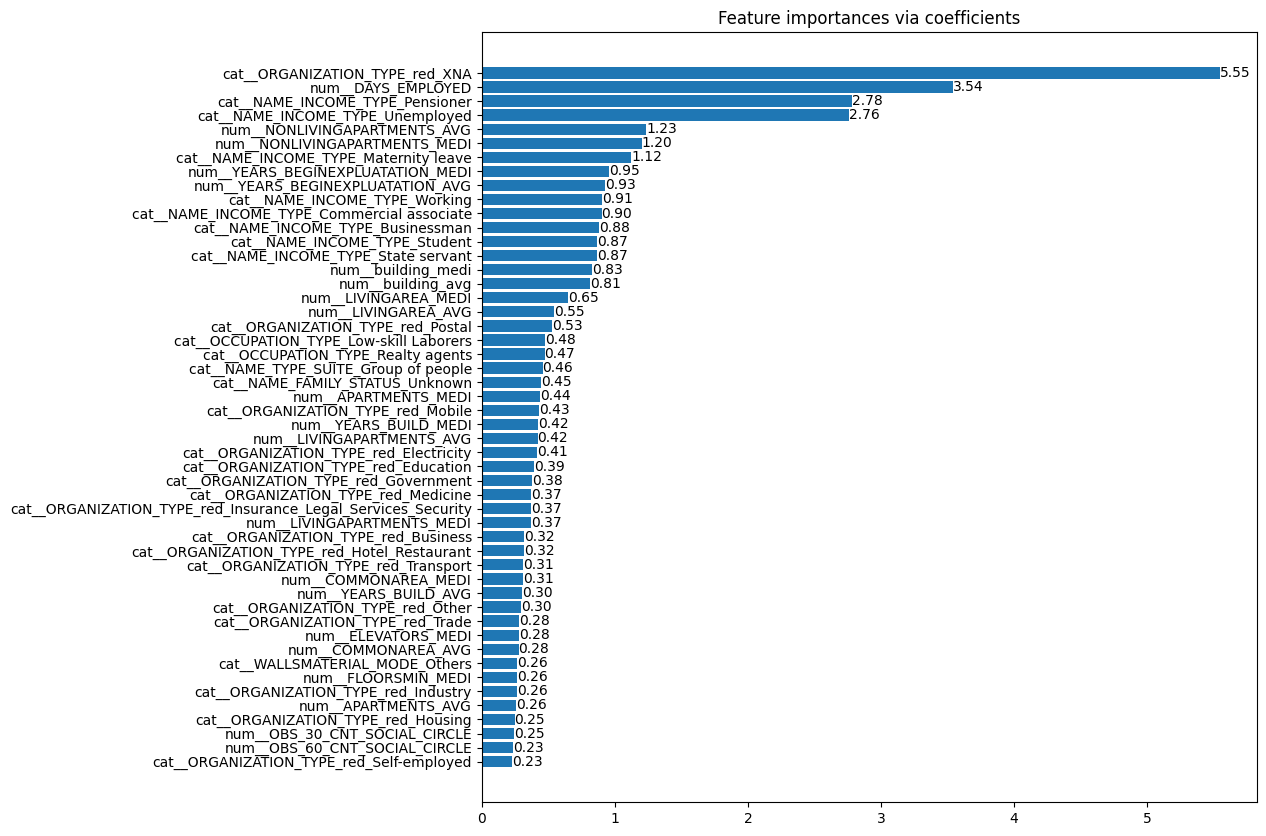

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(ridge_df))
hbars = ax.barh(ridge_df['index'][:limit], ridge_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
ridge_cv_top_features = ridge_df['index'][:limit].sort_values().values.tolist()

#### LightGBM Feature Importances

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

LGBClas_basic = LGBMClassifier(class_weight ='balanced', verbosity=-100)

pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', LGBClas_basic))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(LGBClas_basic.feature_importances_)

lgb_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
lgb_df.reset_index(inplace=True)
lgb_df = lgb_df.sort_values(by='Importance',ascending=False)

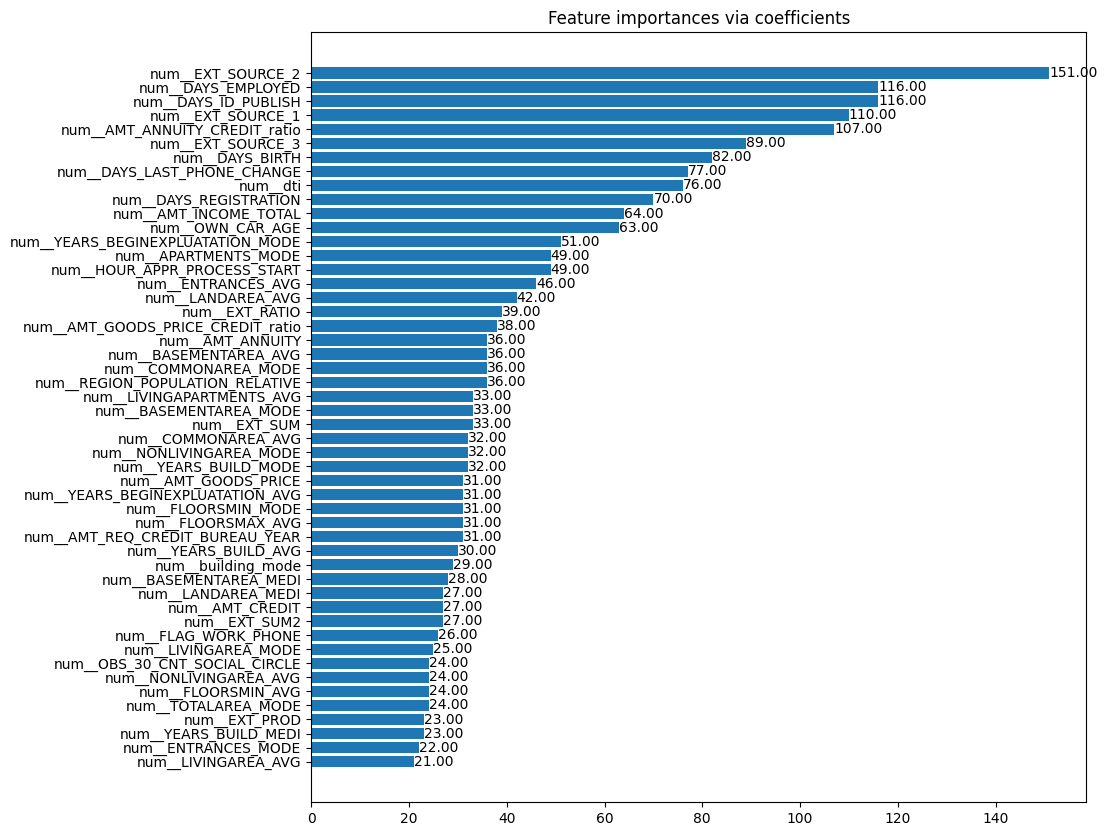

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(lgb_df))

hbars = ax.barh(lgb_df['index'][:limit], lgb_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
lgb_cv_top_features = lgb_df['index'][:limit].sort_values().values.tolist()

#### Recursive Feature Elimination (RFECV)

Attempt to reduce the number of features through recursive feature elimination:

In [ ]:
%%time
# the error:  "when importance_getter=='auto', the underlying estimator X
# should have 'coef_' or 'feature_importances_' attribute."
# limits the pool of estimator that are easy to use:

#model = LinReg
#model = LogReg
#model = RFClas
#model = DTClas
model = LGBMClassifier(class_weight ='balanced', verbosity=-100)


rfecv = RFECV(estimator=model,
              cv=cvSKs, # for classification, cvRSK takes 2 hours! cvSKs 13min
              scoring = scoring,
              )


pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', rfecv))

pipeline = Pipeline(pipe_steps)

pipeline.fit(X_train,y_train)

CPU times: user 13min 26s, sys: 6.74 s, total: 13min 33s
Wall time: 13min 39s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLO...
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE',
                                                   'ORGANIZATION_TYPE_red'])])),
                ('Feature Selection',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                       estimator=LGBMClassifier(class_weight='balanced',
                                                verbosity=-100),
                       scoring='balanced_accuracy'))])

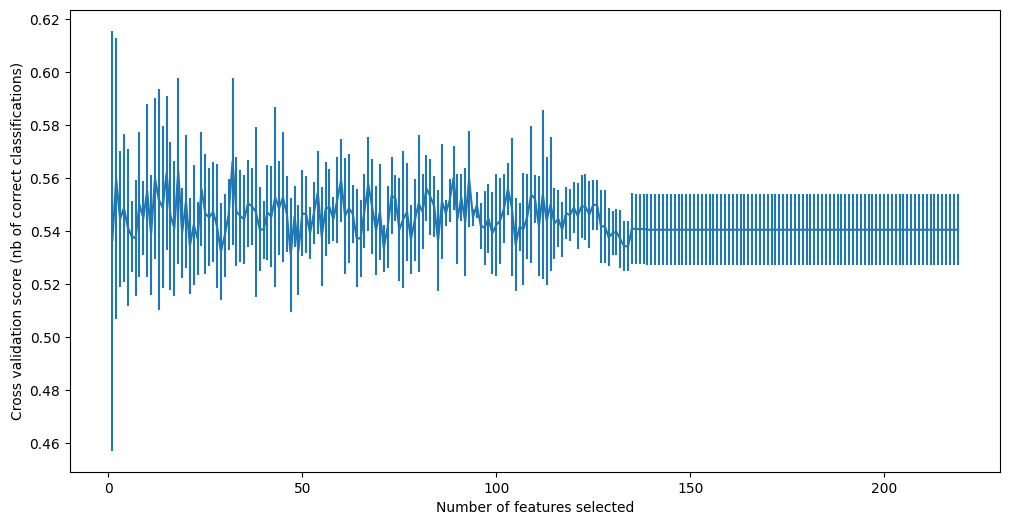

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [ ]:
rfecv_df = pd.DataFrame(rfecv.ranking_,index=new_cols,columns=['Rank']) # sklearn
rfecv_df.reset_index(inplace=True)
rfecv_df = rfecv_df.sort_values(by='Rank',ascending=True)
#rfecv_df

In [ ]:
number_last_rank1 = (len(rfecv_df) - rfecv_df.iloc[-1:].Rank + 1).values[0]
RFECV_results = rfecv_df['index'][:number_last_rank1].values.tolist()

print(number_last_rank1, 'features found:')
RFECV_results.sort()
RFECV_results

32 features found:


['num__AMT_ANNUITY',
 'num__AMT_ANNUITY_CREDIT_ratio',
 'num__AMT_INCOME_TOTAL',
 'num__APARTMENTS_MODE',
 'num__BASEMENTAREA_AVG',
 'num__COMMONAREA_AVG',
 'num__COMMONAREA_MODE',
 'num__DAYS_BIRTH',
 'num__DAYS_EMPLOYED',
 'num__DAYS_ID_PUBLISH',
 'num__DAYS_LAST_PHONE_CHANGE',
 'num__DAYS_REGISTRATION',
 'num__ENTRANCES_AVG',
 'num__EXT_SOURCE_1',
 'num__EXT_SOURCE_2',
 'num__EXT_SOURCE_3',
 'num__EXT_SUM',
 'num__FLOORSMAX_AVG',
 'num__FLOORSMIN_AVG',
 'num__HOUR_APPR_PROCESS_START',
 'num__LANDAREA_AVG',
 'num__LIVINGAPARTMENTS_AVG',
 'num__LIVINGAREA_AVG',
 'num__NONLIVINGAREA_AVG',
 'num__OBS_30_CNT_SOCIAL_CIRCLE',
 'num__OWN_CAR_AGE',
 'num__REGION_POPULATION_RELATIVE',
 'num__YEARS_BEGINEXPLUATATION_AVG',
 'num__YEARS_BEGINEXPLUATATION_MODE',
 'num__YEARS_BUILD_MODE',
 'num__building_avg',
 'num__dti']

In [ ]:
mean_score = np.max(rfecv.cv_results_["mean_test_score"]).round(5)
print('The mean', scoring, 'scoring is:', mean_score)

The mean balanced_accuracy scoring is: 0.56631


### Comparison

In [ ]:
KBest_cols, ridge_cv_top_features, lgb_cv_top_features, RFECV_results

(['num__FLAG_OWN_CAR',
  'num__AMT_INCOME_TOTAL',
  'num__AMT_CREDIT',
  'num__AMT_ANNUITY',
  'num__AMT_GOODS_PRICE',
  'num__REGION_POPULATION_RELATIVE',
  'num__DAYS_BIRTH',
  'num__DAYS_ID_PUBLISH',
  'num__OWN_CAR_AGE',
  'num__FLAG_WORK_PHONE',
  'num__REGION_RATING_CLIENT',
  'num__REGION_RATING_CLIENT_W_CITY',
  'num__REG_REGION_NOT_LIVE_REGION',
  'num__REG_REGION_NOT_WORK_REGION',
  'num__REG_CITY_NOT_LIVE_CITY',
  'num__REG_CITY_NOT_WORK_CITY',
  'num__LIVE_CITY_NOT_WORK_CITY',
  'num__EXT_SOURCE_1',
  'num__EXT_SOURCE_2',
  'num__ELEVATORS_AVG',
  'num__FLOORSMAX_AVG',
  'num__LIVINGAREA_AVG',
  'num__ELEVATORS_MODE',
  'num__FLOORSMAX_MODE',
  'num__ELEVATORS_MEDI',
  'num__LIVINGAREA_MEDI',
  'num__DEF_30_CNT_SOCIAL_CIRCLE',
  'num__DEF_60_CNT_SOCIAL_CIRCLE',
  'num__FLAG_DOCUMENT_3',
  'num__FLAG_DOCUMENT_17',
  'num__EXT_RATIO',
  'num__AMT_GOODS_PRICE_CREDIT_ratio',
  'num__FLAG_DOCUMENT_SUM',
  'cat__NAME_TYPE_SUITE_Missing',
  'cat__NAME_INCOME_TYPE_Working',
  'cat_

In [ ]:
KBest_cols_app_only = KBest_cols
ridge_cv_top_features_app_only = ridge_cv_top_features
lgb_cv_top_features_app_only = lgb_cv_top_features
RFECV_results_app_only = RFECV_results

# Feature Selection - Payment Issues - All Tables

#### Load Data - All Tables Combined

In [ ]:
%%capture
#! mkdir home_folder+'cleaned/'
df_final = dd.read_csv(home_folder+'cleaned/HC_app_train_combined.csv')

In [ ]:
size_df_final = [df_final.shape[0].compute(),  df_final.shape[1]]

print('The combined dataset has', size_df_final[0], 'rows and', size_df_final[1], 'features.')

The combined dataset has 307511 rows and 291 features.


Let's only take rows the have entries in every table:

In [ ]:
#df_select = df_final.loc[~(df_final.flag_table_pos_cash_sum>0) &
#                         ~(df_final.flag_table_credit_card_sum>0) &
#                         ~(df_final.flag_table_bureau>0)]

In [ ]:
#size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

#print('The combined dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

In [ ]:
#app_features = df_select.columns[:134]  # features before 'AMT_ANNUITY_prev'
#app_features

In [ ]:
#df_select = df_select[app_features]

In [ ]:
# flag_table_install
# flag_table_pos_cash
# flag_table_credit_card
# flag_table_bureau

df_select = df_final.loc[(df_final.flag_table_pos_cash_sum>0) &
                         (df_final.flag_table_credit_card_sum>0) &
                         (df_final.flag_table_bureau>0)]

In [ ]:
size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

print('The combined dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

The combined dataset has 65001 rows and 291 features.


In [ ]:
nan_overview_df = dfunc.nan_type_overview_dd(df_select, size_df_select[0])
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,type,NaN[abs],NaN[%]
SK_ID_CURR,int64,0,0.000000
TARGET,int64,0,0.000000
NAME_CONTRACT_TYPE,string,0,0.000000
CODE_GENDER,float64,0,0.000000
FLAG_OWN_CAR,int64,0,0.000000
FLAG_OWN_REALTY,int64,0,0.000000
CNT_CHILDREN,int64,0,0.000000
AMT_INCOME_TOTAL,float64,0,0.000000
AMT_CREDIT,float64,0,0.000000
AMT_ANNUITY,float64,7,0.000000


##### Sample

In [ ]:
SAMPLES = 10000
frac = SAMPLES/size_df_select[0]

if frac > 1:
    data = df_select.compute()
else:
    data = df_select.sample(frac=frac, replace=False, random_state=10).compute()

### Test Train Split & Preprocessing Pipeline

Select features to use:

In [ ]:
#num_feat_select = data.select_dtypes(include=np.number).columns.tolist()
#cat_feat_select = data.select_dtypes(exclude=np.number).columns.tolist()

features = data.columns.tolist()

... and split data:

In [ ]:
features = data.columns.tolist()
features = dfunc.drop_from_list(features, ['TARGET', 'SK_ID_CURR'])
target = 'TARGET'

X_train, X_test, y_train, y_test, labels = split_model_data(data, features, target)

labels = ['No\nPayment\nIssues', 'Payment\nIssues']

Class proportions:
TARGET
0    0.913
1    0.087
Name: count, dtype: float64


#### Define the preprocessing Pipeline and gather the new Columns Names

In [ ]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
#ord_feat = ordinal_encode.keys()
ordinal_encode = {}

In [ ]:
for col in cat_feat:
    X_train[col] = X_train[col].fillna('Missing') # Or any other strategy to handle missing values


In [ ]:
preprocessor_scaled, preprocessor_tree = setup_preprocessor(cat_feat = cat_feat,
                                                            num_feat = num_feat,
                                                            ordinal_encode = ordinal_encode
                                                            )
X_train_prep, new_cols = preprocess_X(X_train, preprocessor_scaled)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [ ]:
#X_transformer_steps_scaled = [('preprocessor', preprocessor_scaled)]
#X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = [('preprocessor', preprocessor_scaled)].copy()
pipe_prep_steps_tree = [('preprocessor', preprocessor_tree)].copy()

In [ ]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )

The number of features increased from 289 to 371 after preprocessing.


In [ ]:
# how to access infos:
# preprocessor.transformers[0][2]

### Feature Selection

Exploring best features from SelectKBest, RidgeCV, LightGBM, and RFE for given data subset.



In [ ]:
n_ranks = 50

#### SelectKBest

In [ ]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('f_classif', SelectKBest(score_func=f_classif, k=min(n_ranks, len(X_train.columns)))))

KBest_pipe = Pipeline(pipe_steps)

KBest_pipe.fit(X_train,y_train)


KBest = KBest_pipe.named_steps['f_classif'].get_feature_names_out()

KBest_cols = []
for feature in KBest:
    index_nr = int(feature.replace('x', ''))
    KBest_cols.append(new_cols[index_nr])

#KBest_cols

#### RidgeCV

Another try-out: a regularization algorithm that returns features importances:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


ridge = RidgeClassifierCV(alphas=np.logspace(-6, 6, num=5),
                          scoring = scoring, cv = cvSK)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('Feature Selection', ridge))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(ridge.coef_[0])

ridge_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
ridge_df.reset_index(inplace=True)
ridge_df = ridge_df.sort_values(by='Importance',ascending=False)

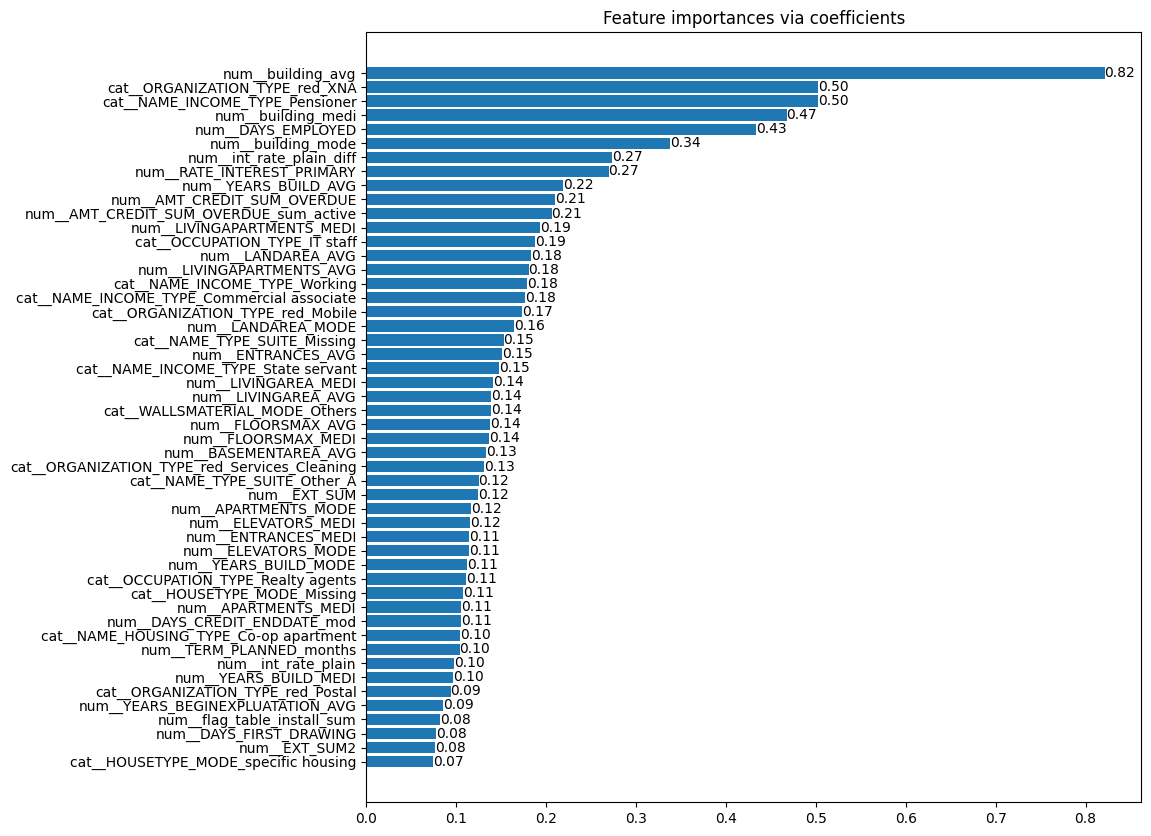

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(ridge_df))
hbars = ax.barh(ridge_df['index'][:limit], ridge_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
ridge_cv_top_features = ridge_df['index'][:limit].sort_values().values.tolist()

#### LightGBM Feature Importances

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

LGBClas_basic = LGBMClassifier(class_weight ='balanced', verbosity=-100)

pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', LGBClas_basic))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(LGBClas_basic.feature_importances_)

lgb_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
lgb_df.reset_index(inplace=True)
lgb_df = lgb_df.sort_values(by='Importance',ascending=False)

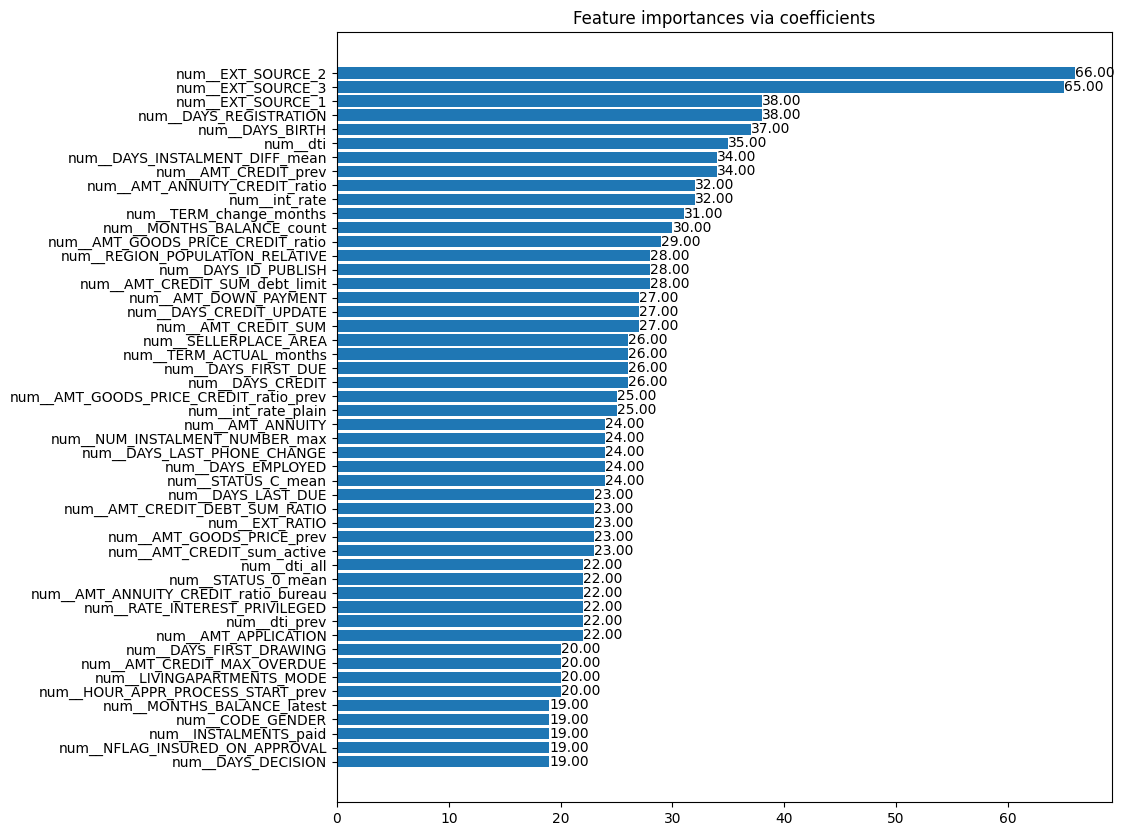

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(lgb_df))

hbars = ax.barh(lgb_df['index'][:limit], lgb_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
lgb_cv_top_features = lgb_df['index'][:limit].sort_values().values.tolist()

#### Recursive Feature Elimination (RFECV)

Attempt to reduce the number of features through recursive feature elimination:

In [ ]:
%%time
# the error:  "when importance_getter=='auto', the underlying estimator X
# should have 'coef_' or 'feature_importances_' attribute."
# limits the pool of estimator that are easy to use:

#model = LinReg
#model = LogReg
#model = RFClas
#model = DTClas
model = LGBMClassifier(class_weight ='balanced', verbosity=-100)


rfecv = RFECV(estimator=model,
              cv=cvSKs, # for classification
              scoring = scoring,
              )


pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', rfecv))

pipeline = Pipeline(pipe_steps)

pipeline.fit(X_train,y_train)

# 1h 35min for lgb on all columns & 10000 rows!

CPU times: user 1h 31min 57s, sys: 29.8 s, total: 1h 32min 26s
Wall time: 1h 32min 48s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLO...
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE',
                                                   'ORGANIZATION_TYPE_red'])])),
                ('Feature Selection',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                       estimator=LGBMClassifier(class_weight='balanced',
                                                verbosity=-100),
                       scoring='balanced_accuracy'))])

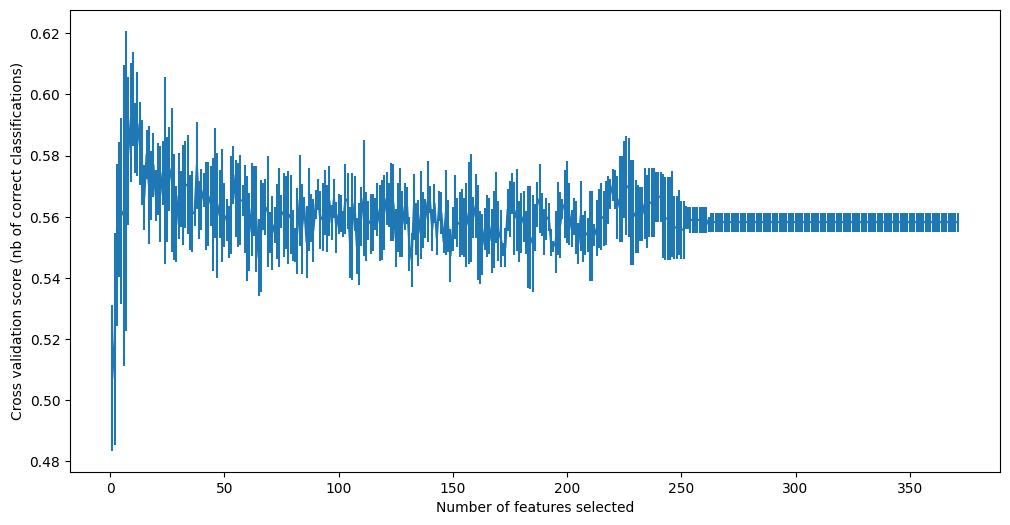

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [ ]:
rfecv_df = pd.DataFrame(rfecv.ranking_,index=new_cols,columns=['Rank']) # sklearn
rfecv_df.reset_index(inplace=True)
rfecv_df = rfecv_df.sort_values(by='Rank',ascending=True)
#rfecv_df

In [ ]:
number_last_rank1 = (len(rfecv_df) - rfecv_df.iloc[-1:].Rank + 1).values[0]
RFECV_results = rfecv_df['index'][:number_last_rank1].values.tolist()

print(number_last_rank1, 'features found:')
RFECV_results.sort()
RFECV_results

10 features found:


['num__AMT_ANNUITY_CREDIT_ratio',
 'num__AMT_CREDIT_SUM',
 'num__AMT_GOODS_PRICE_CREDIT_ratio_prev',
 'num__DAYS_FIRST_DUE',
 'num__EXT_SOURCE_1',
 'num__EXT_SOURCE_2',
 'num__EXT_SOURCE_3',
 'num__LANDAREA_MODE',
 'num__dti',
 'num__int_rate_plain']

In [ ]:
mean_score = np.max(rfecv.cv_results_["mean_test_score"]).round(5)
print('The mean', scoring, 'scoring is:', mean_score)

The mean balanced_accuracy scoring is: 0.59851


### Comparison

In [ ]:
KBest_cols, ridge_cv_top_features, lgb_cv_top_features, RFECV_results

(['num__CODE_GENDER',
  'num__AMT_CREDIT',
  'num__AMT_GOODS_PRICE',
  'num__DAYS_BIRTH',
  'num__DAYS_ID_PUBLISH',
  'num__REGION_RATING_CLIENT',
  'num__REGION_RATING_CLIENT_W_CITY',
  'num__EXT_SOURCE_1',
  'num__EXT_SOURCE_2',
  'num__EXT_SOURCE_3',
  'num__DAYS_LAST_PHONE_CHANGE',
  'num__EXT_SUM',
  'num__EXT_SUM2',
  'num__EXT_PROD',
  'num__AMT_GOODS_PRICE_CREDIT_ratio',
  'num__AMT_DOWN_PAYMENT',
  'num__RATE_DOWN_PAYMENT',
  'num__DAYS_DECISION',
  'num__CNT_PAYMENT',
  'num__DAYS_FIRST_DRAWING',
  'num__DAYS_FIRST_DUE',
  'num__int_rate_plain',
  'num__AMT_ANNUITY_CREDIT_ratio_prev',
  'num__AMT_ANNUITY_plain_ratio',
  'num__AMT_GOODS_PRICE_CREDIT_ratio_prev',
  'num__AMT_DOWN_PAYMENT_CREDIT_ratio',
  'num__CNT_PAYMENT_inv',
  'num__NAME_CONTRACT_TYPE_Consumer_loans',
  'num__NAME_CONTRACT_STATUS_Approved',
  'num__NAME_CONTRACT_STATUS_Refused',
  'num__NAME_PORTFOLIO_POS',
  'num__NAME_PRODUCT_TYPE_walk-in',
  'num__NAME_YIELD_GROUP_low_normal',
  'num__CNT_INSTALMENT_max',

In [ ]:
KBest_cols_all = KBest_cols
ridge_cv_top_features_all = ridge_cv_top_features
lgb_cv_top_features_all = lgb_cv_top_features
RFECV_results_all = RFECV_results

# Feature Selection - Payment Issues - Loan Selected

#### Load Data - Revolving Loans

In [ ]:
%%capture
#! mkdir home_folder+'cleaned/'
df_final = dd.read_csv(home_folder+'cleaned/HC_app_train_combined.csv')

In [ ]:
size_df_final = [df_final.shape[0].compute(),  df_final.shape[1]]

print('The combined dataset has', size_df_final[0], 'rows and', size_df_final[1], 'features.')

The combined dataset has 307511 rows and 291 features.


Let's only take rows for revolving loan:

In [ ]:
# flag_table_install
# flag_table_pos_cash
# flag_table_credit_card
# flag_table_bureau

df_select = df_final.loc[(df_final.NAME_CONTRACT_TYPE=='Revolving loans')]

In [ ]:
size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

print('The combined dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

The combined dataset has 29279 rows and 291 features.


In [ ]:
nan_overview_df = dfunc.nan_type_overview_dd(df_select, size_df_select[0])
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,type,NaN[abs],NaN[%]
SK_ID_CURR,int64,0,0.000000
TARGET,int64,0,0.000000
NAME_CONTRACT_TYPE,string,0,0.000000
CODE_GENDER,float64,4,0.000000
FLAG_OWN_CAR,int64,0,0.000000
FLAG_OWN_REALTY,int64,0,0.000000
CNT_CHILDREN,int64,0,0.000000
AMT_INCOME_TOTAL,float64,0,0.000000
AMT_CREDIT,float64,0,0.000000
AMT_ANNUITY,float64,0,0.000000


##### Sample

In [ ]:
SAMPLES = 10000
frac = SAMPLES/size_df_select[0]

if frac > 1:
    data = df_select.compute()
else:
    data = df_select.sample(frac=frac, replace=False, random_state=10).compute()

### Test Train Split & Preprocessing Pipeline

Select features to use:

In [ ]:
#num_feat_select = data.select_dtypes(include=np.number).columns.tolist()
#cat_feat_select = data.select_dtypes(exclude=np.number).columns.tolist()

features = data.columns.tolist()

... and split data:

In [ ]:
features = data.columns.tolist()
features = dfunc.drop_from_list(features, ['TARGET', 'SK_ID_CURR'])
target = 'TARGET'

X_train, X_test, y_train, y_test, labels = split_model_data(data, features, target)

labels = ['No\nPayment\nIssues', 'Payment\nIssues']

Class proportions:
TARGET
0    0.9477
1    0.0523
Name: count, dtype: float64


#### Define the preprocessing Pipeline and gather the new Columns Names

In [ ]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
#ord_feat = ordinal_encode.keys()
ordinal_encode = {}

In [ ]:
for col in cat_feat:
    X_train[col] = X_train[col].fillna('Missing') # Or any other strategy to handle missing values


In [ ]:
preprocessor_scaled, preprocessor_tree = setup_preprocessor(cat_feat = cat_feat,
                                                            num_feat = num_feat,
                                                            ordinal_encode = ordinal_encode
                                                            )
X_train_prep, new_cols = preprocess_X(X_train, preprocessor_scaled)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [ ]:
#X_transformer_steps_scaled = [('preprocessor', preprocessor_scaled)]
#X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = [('preprocessor', preprocessor_scaled)].copy()
pipe_prep_steps_tree = [('preprocessor', preprocessor_tree)].copy()

In [ ]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )

The number of features increased from 289 to 375 after preprocessing.


In [ ]:
# how to access infos:
# preprocessor.transformers[0][2]

### Feature Selection

Exploring best features from SelectKBest, RidgeCV, LightGBM, and RFE for given data subset.



In [ ]:
n_ranks = 50

#### SelectKBest

In [ ]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('f_classif', SelectKBest(score_func=f_classif, k=min(n_ranks, len(X_train.columns)))))

KBest_pipe = Pipeline(pipe_steps)

KBest_pipe.fit(X_train,y_train)


KBest = KBest_pipe.named_steps['f_classif'].get_feature_names_out()

KBest_cols = []
for feature in KBest:
    index_nr = int(feature.replace('x', ''))
    KBest_cols.append(new_cols[index_nr])

#KBest_cols

#### RidgeCV

Another try-out: a regularization algorithm that returns features importances:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


ridge = RidgeClassifierCV(alphas=np.logspace(-6, 6, num=5),
                          scoring = scoring, cv = cvSK)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('Feature Selection', ridge))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(ridge.coef_[0])

ridge_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
ridge_df.reset_index(inplace=True)
ridge_df = ridge_df.sort_values(by='Importance',ascending=False)

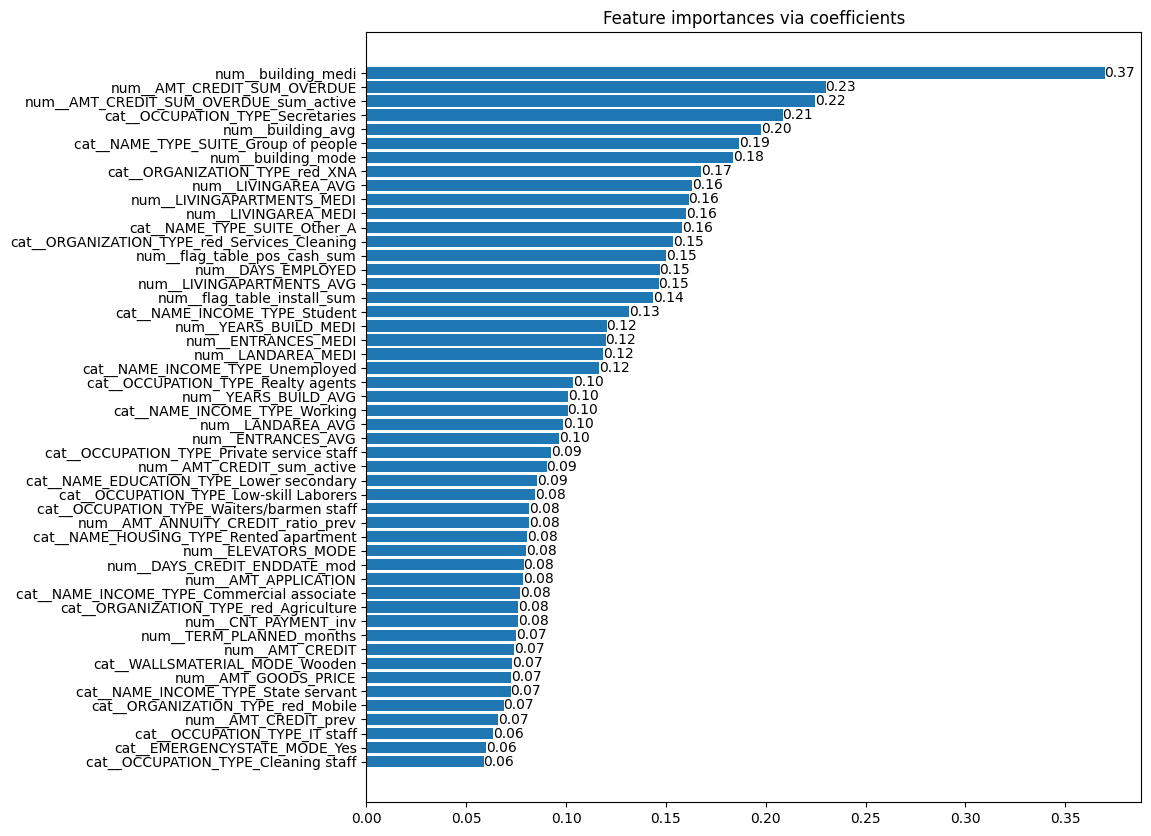

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(ridge_df))
hbars = ax.barh(ridge_df['index'][:limit], ridge_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
ridge_cv_top_features = ridge_df['index'][:limit].sort_values().values.tolist()

#### LightGBM Feature Importances

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

LGBClas_basic = LGBMClassifier(class_weight ='balanced', verbosity=-100)

pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', LGBClas_basic))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(LGBClas_basic.feature_importances_)

lgb_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
lgb_df.reset_index(inplace=True)
lgb_df = lgb_df.sort_values(by='Importance',ascending=False)

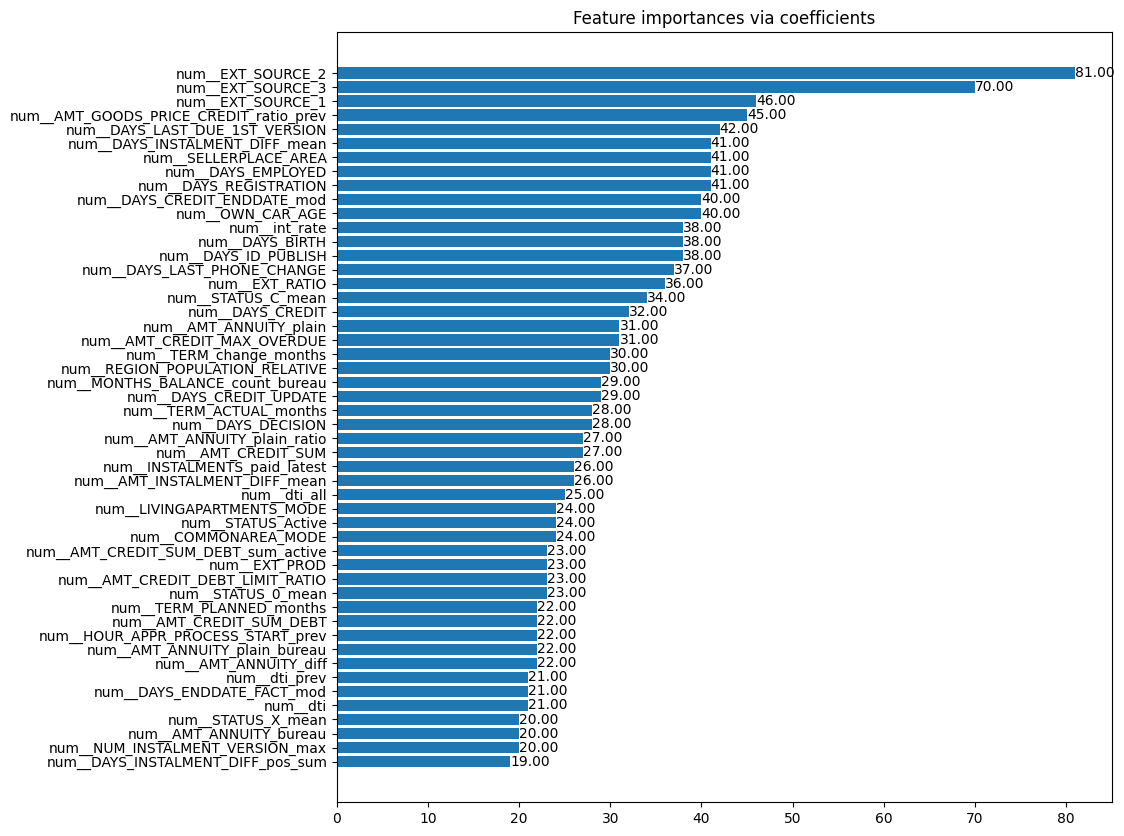

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(n_ranks, len(lgb_df))

hbars = ax.barh(lgb_df['index'][:limit], lgb_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

In [ ]:
lgb_cv_top_features = lgb_df['index'][:limit].sort_values().values.tolist()

#### Recursive Feature Elimination (RFECV)

Attempt to reduce the number of features through recursive feature elimination:

In [ ]:
%%time
# the error:  "when importance_getter=='auto', the underlying estimator X
# should have 'coef_' or 'feature_importances_' attribute."
# limits the pool of estimator that are easy to use:

#model = LinReg
#model = LogReg
#model = RFClas
#model = DTClas
model = LGBMClassifier(class_weight ='balanced', verbosity=-100)


rfecv = RFECV(estimator=model,
              cv=cvSKs, # for classification
              scoring = scoring,
              )


pipe_steps = pipe_prep_steps_tree.copy()
pipe_steps.append(('Feature Selection', rfecv))

pipeline = Pipeline(pipe_steps)

pipeline.fit(X_train,y_train)

# 1h 35min for lgb on all columns & 10000 rows!

CPU times: user 1h 30min 12s, sys: 35.1 s, total: 1h 30min 47s
Wall time: 1h 31min 8s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLO...
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE',
                                                   'ORGANIZATION_TYPE_red'])])),
                ('Feature Selection',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                       estimator=LGBMClassifier(class_weight='balanced',
                                                verbosity=-100),
                       scoring='balanced_accuracy'))])

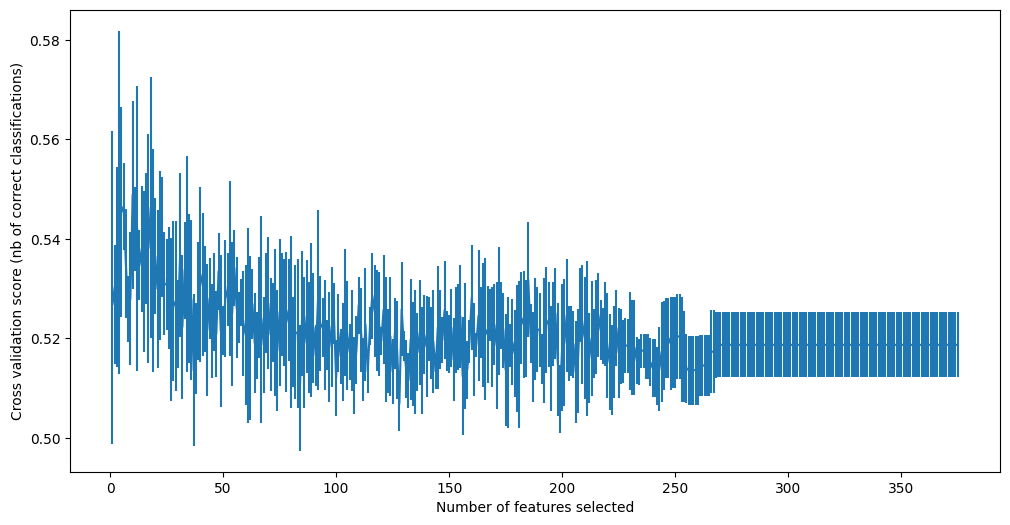

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [ ]:
rfecv_df = pd.DataFrame(rfecv.ranking_,index=new_cols,columns=['Rank']) # sklearn
rfecv_df.reset_index(inplace=True)
rfecv_df = rfecv_df.sort_values(by='Rank',ascending=True)
#rfecv_df

In [ ]:
number_last_rank1 = (len(rfecv_df) - rfecv_df.iloc[-1:].Rank + 1).values[0]
RFECV_results = rfecv_df['index'][:number_last_rank1].values.tolist()

print(number_last_rank1, 'features found:')
RFECV_results.sort()
RFECV_results

10 features found:


['num__AMT_CREDIT_SUM',
 'num__COMMONAREA_AVG',
 'num__DAYS_BIRTH',
 'num__DAYS_DECISION',
 'num__DAYS_INSTALMENT_DIFF_mean',
 'num__DAYS_LAST_DUE_1ST_VERSION',
 'num__EXT_SOURCE_1',
 'num__EXT_SOURCE_2',
 'num__EXT_SOURCE_3',
 'num__building_mode']

In [ ]:
mean_score = np.max(rfecv.cv_results_["mean_test_score"]).round(5)
print('The mean', scoring, 'scoring is:', mean_score)

The mean balanced_accuracy scoring is: 0.54887


### Comparison

In [ ]:
KBest_cols, ridge_cv_top_features, lgb_cv_top_features, RFECV_results

(['num__AMT_INCOME_TOTAL',
  'num__AMT_CREDIT',
  'num__AMT_ANNUITY',
  'num__AMT_GOODS_PRICE',
  'num__DAYS_BIRTH',
  'num__DAYS_ID_PUBLISH',
  'num__OWN_CAR_AGE',
  'num__FLAG_WORK_PHONE',
  'num__REGION_RATING_CLIENT_W_CITY',
  'num__EXT_SOURCE_1',
  'num__EXT_SOURCE_2',
  'num__EXT_SOURCE_3',
  'num__FLOORSMIN_AVG',
  'num__FLOORSMAX_MODE',
  'num__FLOORSMIN_MODE',
  'num__FLOORSMIN_MEDI',
  'num__DEF_30_CNT_SOCIAL_CIRCLE',
  'num__DEF_60_CNT_SOCIAL_CIRCLE',
  'num__DAYS_LAST_PHONE_CHANGE',
  'num__EXT_SUM',
  'num__EXT_SUM2',
  'num__EXT_PROD',
  'num__AMT_ANNUITY_prev',
  'num__AMT_APPLICATION',
  'num__DAYS_DECISION',
  'num__AMT_ANNUITY_plain',
  'num__int_rate_plain',
  'num__AMT_ANNUITY_plain_ratio',
  'num__AMT_GOODS_PRICE_CREDIT_ratio_prev',
  'num__NAME_CLIENT_TYPE_New',
  'num__NAME_YIELD_GROUP_high',
  'num__NAME_YIELD_GROUP_low_action',
  'num__MONTHS_BALANCE_latest',
  'num__AMT_ANNUITY_sum_active_prev',
  'num__AMT_APPLICATION_sum_active',
  'num__AMT_CREDIT_sum_activ

In [ ]:
KBest_cols_revolv = KBest_cols
ridge_cv_top_features_revolv = ridge_cv_top_features
lgb_cv_top_features_revolv = lgb_cv_top_features
RFECV_results_revolv = RFECV_results

# Results

**RFECV balanced_accuracy mean test score:**

.

**Previous Runs:**

data: **all** tables (mostly inner merges; only 11000 rows available - capped to 10000)
* DTClas on all features: **0.55487**, 15 features (~36 minutes)
* DTClas on all **numerical** features: **0.55804**, 16 features

* DTClas on all **categorical** features: **0.52219**, all 72 features
* DTClas on all features from **app** table: **0.56034**, 183 features

* DTClas on all features from **prev** table: **0.54227**, 51 features

* DTClas on all features from **bureau** table: **0.53194**, all 39 features

* LightGBM on all features from **all** tables : **0.64399**, 8 features (~1 hour)

* DTClas on merged features from **all** tables  found by LightGBM and DTClas: **0.55772**, 14 features

* LightGBM on all features  + new engineered features: **0.61672**, 26 features

.

**This Notebook:**

data: **all** tables (outer merges,  >60000 rows available - capped to 10000)
* LightGBM on all features + new engineered features: **0.61073**,  16 features


data: **app** table only (~2000 rows available)
* LightGBM on all features + new features engineered on app table alone: **0.58066**, 29 features


### Collected Lists

In [ ]:
RFECV_LightGBM_app_only = [
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'ENTRANCES_AVG',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'LANDAREA_MODE',
 'HOUR_APPR_PROCESS_START',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_AVG',
 'NONLIVINGAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'COMMONAREA_MEDI',
 'EXT_SUM2',
 'dti',
 'OWN_CAR_AGE',
 'EXT_RATIO',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY_CREDIT_ratio',
 'DAYS_BIRTH',
 'building_avg',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL']

RFECV_LightGBM_app_only.sort()
RFECV_LightGBM_app_only

['AMT_ANNUITY_CREDIT_ratio',
 'AMT_INCOME_TOTAL',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'COMMONAREA_MEDI',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'ENTRANCES_AVG',
 'EXT_RATIO',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SUM2',
 'FLOORSMIN_AVG',
 'HOUR_APPR_PROCESS_START',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_MODE',
 'OWN_CAR_AGE',
 'REGION_POPULATION_RELATIVE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_MODE',
 'building_avg',
 'dti']

In [ ]:
# LightGBM RFECV
RFECV_LightGBM_all_tables_all_features_cleaned = [
    'EXT_SOURCE_1',
    'DAYS_LAST_DUE_1ST_VERSION',
    'EXT_SOURCE_3',
    'AMT_APPLICATION',
    'AMT_ANNUITY',
    'TOTALAREA_MODE',
    'DAYS_BIRTH',
    'EXT_SOURCE_2']

RFECV_LightGBM_all_tables_all_features_engineered_cleaned = [
 'AMT_GOODS_PRICE_CREDIT_ratio',
 'DAYS_LAST_PHONE_CHANGE',
 'YEARS_BUILD_AVG',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_CREDIT_DEBT_SUM_RATIO',
 'STATUS_Completed',
 'DAYS_ENDDATE_FACT_mod',
 'int_rate_plain',
 'AMT_ANNUITY_plain',
 'STATUS_0_mean',
 'AMT_ANNUITY_CREDIT_ratio_bureau',
 'EXT_RATIO',
 'dti',
 'AMT_CREDIT_SUM_sum_active',
 'EXT_SUM',
 'AMT_APPLICATION',
 'TERM_ACTUAL_months',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START_prev',
 'DAYS_REGISTRATION',
 'DAYS_CREDIT',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'DAYS_INSTALMENT_DIFF_mean']

# Decision Tree RFECV
RFECV_DTC_all_tables_all_features_cleaned = [
'DAYS_DECISION',
'COMMONAREA_AVG',
'YEARS_BUILD_AVG',
'TOTALAREA_MODE',
'EXT_SOURCE_3',
'EXT_SOURCE_2',
'EXT_SOURCE_1',
'TERM_PLANNED_months',
'STATUS_0_mean',
'OWN_CAR_AGE',
'DAYS_INSTALMENT_DIFF_mean',
'DAYS_BIRTH',
'DAYS_EMPLOYED',
'AMT_ANNUITY']

common_RFECV_features = list(set(RFECV_LightGBM_all_tables_all_features_cleaned) &
                             set(RFECV_LightGBM_all_tables_all_features_engineered_cleaned))

In [ ]:
RFECV_LightGBM_all_tables_all_features_engineered_cleaned = [
 'num__AMT_GOODS_PRICE_CREDIT_ratio',
 'num__DAYS_LAST_PHONE_CHANGE',
 'num__YEARS_BUILD_AVG',
 'num__EXT_SOURCE_3',
 'num__EXT_SOURCE_2',
 'num__EXT_SOURCE_1',
 'num__AMT_CREDIT_DEBT_SUM_RATIO',
 'num__STATUS_Completed',
 'num__DAYS_ENDDATE_FACT_mod',
 'num__int_rate_plain',
 'num__AMT_ANNUITY_plain',
 'num__STATUS_0_mean',
 'num__AMT_ANNUITY_CREDIT_ratio_bureau',
 'num__EXT_RATIO',
 'num__dti',
 'num__AMT_CREDIT_SUM_sum_active',
 'num__EXT_SUM',
 'num__AMT_APPLICATION',
 'num__TERM_ACTUAL_months',
 'num__DAYS_ID_PUBLISH',
 'num__HOUR_APPR_PROCESS_START_prev',
 'num__DAYS_REGISTRATION',
 'num__DAYS_CREDIT',
 'num__DAYS_BIRTH',
 'num__AMT_CREDIT',
 'num__DAYS_INSTALMENT_DIFF_mean']


RFECV_LightGBM_all_tables_all_features = ['num__EXT_SOURCE_1', 'num__DAYS_LAST_DUE_1ST_VERSION',
       'num__EXT_SOURCE_3', 'num__AMT_APPLICATION', 'num__AMT_ANNUITY',
       'num__TOTALAREA_MODE', 'num__DAYS_BIRTH', 'num__EXT_SOURCE_2']


RFECV_DTC_all_tables_all_features = [
'num__SK_ID_CURR',
'num__DAYS_DECISION',
'num__COMMONAREA_AVG',
'num__YEARS_BUILD_AVG',
'num__TOTALAREA_MODE',
'num__EXT_SOURCE_3',
'num__EXT_SOURCE_2',
'num__EXT_SOURCE_1',
'num__TERM_PLANNED_months',
'num__STATUS_0_mean',
'num__OWN_CAR_AGE',
'num__DAYS_INSTALMENT_DIFF_mean',
'num__DAYS_BIRTH',
'num__DAYS_EMPLOYED',
'num__AMT_ANNUITY']


RFECV_DTC_all_tables_cat_features = ['cat__NAME_CONTRACT_TYPE_Cash loans',
       'cat__ORGANIZATION_TYPE_Industry: type 11',
       'cat__ORGANIZATION_TYPE_Housing',
       'cat__ORGANIZATION_TYPE_Government',
       'cat__ORGANIZATION_TYPE_Business Entity Type 3',
       'cat__ORGANIZATION_TYPE_Business Entity Type 2',
       'cat__ORGANIZATION_TYPE_Business Entity Type 1',
       'cat__ORGANIZATION_TYPE_Bank',
       'cat__ORGANIZATION_TYPE_Advertising',
       'cat__ORGANIZATION_TYPE_Industry: type 3',
       'cat__WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_MONDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'cat__OCCUPATION_TYPE_nan', 'cat__OCCUPATION_TYPE_Security staff',
       'cat__OCCUPATION_TYPE_Sales staff',
       'cat__WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'cat__OCCUPATION_TYPE_Managers',
       'cat__ORGANIZATION_TYPE_Kindergarten',
       'cat__ORGANIZATION_TYPE_Other', 'cat__EMERGENCYSTATE_MODE_No',
       'cat__WALLSMATERIAL_MODE_nan', 'cat__WALLSMATERIAL_MODE_Wooden',
       'cat__WALLSMATERIAL_MODE_Stone, brick',
       'cat__WALLSMATERIAL_MODE_Panel', 'cat__WALLSMATERIAL_MODE_Block',
       'cat__HOUSETYPE_MODE_block of flats',
       'cat__FONDKAPREMONT_MODE_nan', 'cat__ORGANIZATION_TYPE_Medicine',
       'cat__FONDKAPREMONT_MODE_reg oper spec account',
       'cat__FONDKAPREMONT_MODE_not specified',
       'cat__ORGANIZATION_TYPE_XNA',
       'cat__ORGANIZATION_TYPE_Transport: type 4',
       'cat__ORGANIZATION_TYPE_Transport: type 3',
       'cat__ORGANIZATION_TYPE_Transport: type 2',
       'cat__ORGANIZATION_TYPE_Trade: type 7',
       'cat__ORGANIZATION_TYPE_Self-employed',
       'cat__ORGANIZATION_TYPE_School',
       'cat__FONDKAPREMONT_MODE_reg oper account',
       'cat__OCCUPATION_TYPE_Laborers', 'cat__EMERGENCYSTATE_MODE_nan',
       'cat__OCCUPATION_TYPE_High skill tech staff',
       'cat__NAME_INCOME_TYPE_Commercial associate',
       'cat__NAME_TYPE_SUITE_Unaccompanied',
       'cat__NAME_TYPE_SUITE_Spouse, partner',
       'cat__NAME_TYPE_SUITE_Family', 'cat__NAME_FAMILY_STATUS_Married',
       'cat__NAME_FAMILY_STATUS_Separated',
       'cat__NAME_FAMILY_STATUS_Single / not married',
       'cat__NAME_FAMILY_STATUS_Widow',
       'cat__NAME_EDUCATION_TYPE_Higher education',
       'cat__FLAG_OWN_REALTY_Y',
       'cat__NAME_HOUSING_TYPE_House / apartment',
       'cat__NAME_HOUSING_TYPE_Municipal apartment',
       'cat__NAME_FAMILY_STATUS_Civil marriage',
       'cat__NAME_HOUSING_TYPE_Office apartment',
       'cat__NAME_HOUSING_TYPE_With parents',
       'cat__OCCUPATION_TYPE_Accountants',
       'cat__OCCUPATION_TYPE_Cleaning staff',
       'cat__OCCUPATION_TYPE_Cooking staff', 'cat__FLAG_OWN_REALTY_N',
       'cat__OCCUPATION_TYPE_Core staff', 'cat__FLAG_OWN_CAR_Y',
       'cat__OCCUPATION_TYPE_Drivers', 'cat__FLAG_OWN_CAR_N',
       'cat__CODE_GENDER_M', 'cat__CODE_GENDER_F',
       'cat__NAME_INCOME_TYPE_Working',
       'cat__NAME_INCOME_TYPE_State servant',
       'cat__NAME_EDUCATION_TYPE_Secondary / secondary special'
]

RFECV_DTC_all_tables_num_features = ['num__DAYS_DECISION', 'num__DAYS_ENDDATE_FACT_mod',
       'num__LIVINGAPARTMENTS_MEDI', 'num__DAYS_FIRST_DUE',
       'num__STATUS_0_mean', 'num__DAYS_CREDIT_UPDATE',
       'num__EXT_SOURCE_1', 'num__OWN_CAR_AGE', 'num__DAYS_ID_PUBLISH',
       'num__DAYS_EMPLOYED', 'num__DAYS_BIRTH', 'num__EXT_SOURCE_3',
       'num__LIVINGAREA_MEDI', 'num__AMT_CREDIT',
       'num__NONLIVINGAREA_AVG', 'num__EXT_SOURCE_2',
       'num__TERM_PLANNED_months']


RFECV_DTC_all_tables_app_features = ['num__CNT_CHILDREN', 'cat__NAME_HOUSING_TYPE_Rented apartment',
       'cat__OCCUPATION_TYPE_Accountants',
       'cat__OCCUPATION_TYPE_Cleaning staff',
       'cat__OCCUPATION_TYPE_Cooking staff',
       'cat__OCCUPATION_TYPE_Core staff', 'cat__OCCUPATION_TYPE_Drivers',
       'cat__OCCUPATION_TYPE_Laborers', 'cat__OCCUPATION_TYPE_Managers',
       'cat__OCCUPATION_TYPE_Secretaries',
       'cat__NAME_HOUSING_TYPE_Office apartment',
       'cat__OCCUPATION_TYPE_Security staff', 'cat__OCCUPATION_TYPE_nan',
       'cat__WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_MONDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'cat__WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
       'cat__ORGANIZATION_TYPE_Advertising',
       'cat__OCCUPATION_TYPE_Waiters/barmen staff',
       'cat__ORGANIZATION_TYPE_Agriculture',
       'cat__NAME_HOUSING_TYPE_Municipal apartment',
       'cat__NAME_FAMILY_STATUS_Widow', 'num__AMT_REQ_CREDIT_BUREAU_HOUR',
       'num__AMT_REQ_CREDIT_BUREAU_DAY',
       'num__AMT_REQ_CREDIT_BUREAU_WEEK',
       'num__AMT_REQ_CREDIT_BUREAU_MON', 'num__AMT_REQ_CREDIT_BUREAU_QRT',
       'num__AMT_REQ_CREDIT_BUREAU_YEAR',
       'cat__NAME_CONTRACT_TYPE_Cash loans', 'cat__CODE_GENDER_F',
       'cat__FLAG_OWN_CAR_N', 'cat__NAME_HOUSING_TYPE_Co-op apartment',
       'cat__FLAG_OWN_CAR_Y', 'cat__NAME_TYPE_SUITE_Other_B',
       'cat__NAME_TYPE_SUITE_Unaccompanied',
       'cat__NAME_INCOME_TYPE_State servant',
       'cat__NAME_EDUCATION_TYPE_Higher education',
       'cat__NAME_EDUCATION_TYPE_Incomplete higher',
       'cat__NAME_FAMILY_STATUS_Civil marriage',
       'cat__NAME_FAMILY_STATUS_Married',
       'cat__NAME_FAMILY_STATUS_Separated',
       'cat__NAME_FAMILY_STATUS_Single / not married',
       'cat__NAME_TYPE_SUITE_Family', 'cat__ORGANIZATION_TYPE_Bank',
       'cat__ORGANIZATION_TYPE_Business Entity Type 3',
       'cat__ORGANIZATION_TYPE_Cleaning',
       'cat__ORGANIZATION_TYPE_Transport: type 2',
       'cat__ORGANIZATION_TYPE_Transport: type 3',
       'cat__ORGANIZATION_TYPE_Transport: type 4',
       'cat__FONDKAPREMONT_MODE_not specified',
       'cat__FONDKAPREMONT_MODE_reg oper account',
       'cat__FONDKAPREMONT_MODE_reg oper spec account',
       'cat__FONDKAPREMONT_MODE_nan',
       'cat__HOUSETYPE_MODE_block of flats',
       'cat__HOUSETYPE_MODE_specific housing',
       'cat__ORGANIZATION_TYPE_Trade: type 7',
       'cat__HOUSETYPE_MODE_terraced house',
       'cat__WALLSMATERIAL_MODE_Block', 'cat__WALLSMATERIAL_MODE_Mixed',
       'cat__WALLSMATERIAL_MODE_Monolithic',
       'cat__WALLSMATERIAL_MODE_Others', 'cat__WALLSMATERIAL_MODE_Panel',
       'cat__WALLSMATERIAL_MODE_Stone, brick',
       'cat__WALLSMATERIAL_MODE_Wooden', 'cat__WALLSMATERIAL_MODE_nan',
       'cat__EMERGENCYSTATE_MODE_No', 'cat__HOUSETYPE_MODE_nan',
       'cat__ORGANIZATION_TYPE_Trade: type 5',
       'cat__ORGANIZATION_TYPE_Trade: type 3',
       'cat__ORGANIZATION_TYPE_Trade: type 2',
       'cat__ORGANIZATION_TYPE_Construction',
       'cat__ORGANIZATION_TYPE_Culture',
       'cat__ORGANIZATION_TYPE_Electricity',
       'cat__ORGANIZATION_TYPE_Emergency',
       'cat__ORGANIZATION_TYPE_Government',
       'cat__ORGANIZATION_TYPE_Hotel', 'cat__ORGANIZATION_TYPE_Housing',
       'cat__ORGANIZATION_TYPE_Industry: type 1',
       'cat__ORGANIZATION_TYPE_Industry: type 11',
       'cat__ORGANIZATION_TYPE_Industry: type 3',
       'cat__ORGANIZATION_TYPE_Industry: type 9',
       'cat__ORGANIZATION_TYPE_Medicine', 'cat__ORGANIZATION_TYPE_Mobile',
       'cat__ORGANIZATION_TYPE_Other', 'cat__ORGANIZATION_TYPE_Postal',
       'cat__ORGANIZATION_TYPE_Religion',
       'cat__ORGANIZATION_TYPE_Restaurant',
       'cat__ORGANIZATION_TYPE_School', 'cat__ORGANIZATION_TYPE_Security',
       'cat__ORGANIZATION_TYPE_Self-employed',
       'cat__ORGANIZATION_TYPE_Services', 'num__FLAG_DOCUMENT_21',
       'num__FLAG_DOCUMENT_20', 'cat__EMERGENCYSTATE_MODE_nan',
       'num__FLAG_DOCUMENT_18', 'num__YEARS_BUILD_MODE',
       'num__COMMONAREA_MODE', 'num__ELEVATORS_MODE',
       'num__ENTRANCES_MODE', 'num__FLOORSMAX_MODE',
       'num__FLOORSMIN_MODE', 'num__LANDAREA_MODE',
       'num__LIVINGAPARTMENTS_MODE', 'num__LIVINGAREA_MODE',
       'num__YEARS_BEGINEXPLUATATION_MODE',
       'num__NONLIVINGAPARTMENTS_MODE', 'num__APARTMENTS_MEDI',
       'num__BASEMENTAREA_MEDI', 'num__YEARS_BEGINEXPLUATATION_MEDI',
       'num__YEARS_BUILD_MEDI', 'num__HOUR_APPR_PROCESS_START',
       'num__REG_CITY_NOT_WORK_CITY', 'num__REGION_RATING_CLIENT_W_CITY',
       'num__COMMONAREA_MEDI', 'num__REGION_RATING_CLIENT',
       'num__NONLIVINGAREA_MODE', 'num__ELEVATORS_MEDI',
       'num__BASEMENTAREA_MODE', 'num__NONLIVINGAREA_AVG',
       'num__EXT_SOURCE_1', 'num__EXT_SOURCE_2', 'num__EXT_SOURCE_3',
       'num__APARTMENTS_AVG', 'num__BASEMENTAREA_AVG',
       'num__YEARS_BEGINEXPLUATATION_AVG', 'num__YEARS_BUILD_AVG',
       'num__COMMONAREA_AVG', 'num__ELEVATORS_AVG',
       'num__APARTMENTS_MODE', 'num__REG_CITY_NOT_LIVE_CITY',
       'num__ENTRANCES_AVG', 'num__REG_REGION_NOT_WORK_REGION',
       'num__FLOORSMAX_AVG', 'num__REG_REGION_NOT_LIVE_REGION',
       'num__FLOORSMIN_AVG', 'num__LANDAREA_AVG',
       'num__LIVINGAPARTMENTS_AVG', 'num__LIVINGAREA_AVG',
       'num__NONLIVINGAPARTMENTS_AVG', 'num__LIVE_REGION_NOT_WORK_REGION',
       'num__CNT_FAM_MEMBERS', 'num__LIVE_CITY_NOT_WORK_CITY',
       'num__FLOORSMAX_MEDI', 'num__FLAG_MOBIL', 'num__OWN_CAR_AGE',
       'num__FLAG_DOCUMENT_5', 'num__ENTRANCES_MEDI',
       'num__FLAG_DOCUMENT_6', 'num__DAYS_REGISTRATION',
       'num__DAYS_EMPLOYED', 'num__DAYS_BIRTH',
       'num__REGION_POPULATION_RELATIVE', 'num__AMT_GOODS_PRICE',
       'num__AMT_ANNUITY', 'num__FLAG_DOCUMENT_8', 'num__FLAG_DOCUMENT_9',
       'num__AMT_CREDIT', 'num__FLAG_DOCUMENT_11',
       'num__FLAG_DOCUMENT_13', 'num__AMT_INCOME_TOTAL',
       'num__FLAG_DOCUMENT_16', 'num__FLAG_DOCUMENT_17',
       'num__FLAG_EMP_PHONE', 'num__FLAG_WORK_PHONE',
       'num__DAYS_ID_PUBLISH', 'num__FLAG_DOCUMENT_3',
       'num__LIVINGAREA_MEDI', 'num__NONLIVINGAREA_MEDI',
       'num__TOTALAREA_MODE', 'num__OBS_30_CNT_SOCIAL_CIRCLE',
       'num__FLAG_EMAIL', 'num__OBS_60_CNT_SOCIAL_CIRCLE',
       'num__FLAG_CONT_MOBILE', 'num__DEF_60_CNT_SOCIAL_CIRCLE',
       'num__FLAG_PHONE', 'num__LIVINGAPARTMENTS_MEDI',
       'num__LANDAREA_MEDI', 'num__FLAG_DOCUMENT_2',
       'num__FLOORSMIN_MEDI', 'num__DAYS_LAST_PHONE_CHANGE',
       'num__NONLIVINGAPARTMENTS_MEDI',]


RFECV_DTC_all_tables_prev_features = ['num__AMT_ANNUITY', 'num__NAME_PAYMENT_TYPE_XNA',
       'num__NAME_TYPE_SUITE_Family', 'num__NAME_TYPE_SUITE_NA',
       'num__NAME_TYPE_SUITE_Unaccompanied', 'num__NAME_CLIENT_TYPE_New',
       'num__NAME_PORTFOLIO_Cards', 'num__NAME_PRODUCT_TYPE_XNA',
       'num__NAME_PRODUCT_TYPE_walk-in', 'num__NAME_PRODUCT_TYPE_x-sell',
       'num__NAME_YIELD_GROUP_XNA', 'num__NAME_YIELD_GROUP_high',
       'num__NAME_YIELD_GROUP_low_normal', 'num__SK_DPD',
       'num__SK_DPD_DEF', 'num__INSTALMENTS_paid', 'num__STATUS_Active',
       'num__STATUS_Completed', 'num__STATUS_Initialized',
       'num__MONTHS_BALANCE_count', 'num__MONTHS_BALANCE_latest',
       'num__NUM_INSTALMENT_NUMBER_max', 'num__DAYS_INSTALMENT_DIFF_mean',
       'num__AMT_INSTALMENT_DIFF_mean',
       'num__DAYS_INSTALMENT_DIFF_pos_sum',
       'num__CNT_INSTALMENT_MATURE_CUM_latest',
       'num__NAME_CONTRACT_STATUS_Unused offer',
       'num__NAME_CONTRACT_STATUS_Refused',
       'num__NAME_TYPE_SUITE_Spouse,_partner', 'num__DAYS_TERMINATION',
       'num__DAYS_DECISION', 'num__SELLERPLACE_AREA', 'num__CNT_PAYMENT',
       'num__DAYS_FIRST_DRAWING', 'num__DAYS_FIRST_DUE',
       'num__DAYS_LAST_DUE_1ST_VERSION', 'num__DAYS_LAST_DUE',
       'num__WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'num__WEEKDAY_APPR_PROCESS_START_MONDAY', 'num__AMT_GOODS_PRICE',
       'num__WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'num__HOUR_APPR_PROCESS_START',
       'num__WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'num__WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'num__AMT_DOWN_PAYMENT', 'num__RATE_DOWN_PAYMENT',
       'num__AMT_APPLICATION', 'num__WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'num__NAME_CONTRACT_TYPE_Cash_loans',
       'num__NAME_CONTRACT_TYPE_Revolving_loans', 'num__AMT_CREDIT',
       'num__WEEKDAY_APPR_PROCESS_START_WEDNESDAY']



Comnparison

In [ ]:
#list(set(RFECV_LightGBM_all_tables_all_features) & set(bureau_features))

In [ ]:
len(RFECV_DTC_all_tables_all_features)

common_all_app = list(set(RFECV_DTC_all_tables_all_features) & set(RFECV_DTC_all_tables_app_features))

common_all_prev = list(set(RFECV_DTC_all_tables_all_features) & set(RFECV_DTC_all_tables_prev_features))

common_all_app, common_all_prev

(['num__YEARS_BUILD_AVG',
  'num__DAYS_BIRTH',
  'num__EXT_SOURCE_3',
  'num__COMMONAREA_AVG',
  'num__TOTALAREA_MODE',
  'num__AMT_ANNUITY',
  'num__OWN_CAR_AGE',
  'num__EXT_SOURCE_1',
  'num__DAYS_EMPLOYED',
  'num__EXT_SOURCE_2'],
 ['num__DAYS_INSTALMENT_DIFF_mean', 'num__DAYS_DECISION', 'num__AMT_ANNUITY'])

In [ ]:
#rfecv.cv_results_["mean_test_score"].round(3)

In [ ]:
RFECV_LightGBM_all_tables_all_features = ['num__EXT_SOURCE_1', 'num__DAYS_LAST_DUE_1ST_VERSION',
       'num__EXT_SOURCE_3', 'num__AMT_APPLICATION', 'num__AMT_ANNUITY',
       'num__TOTALAREA_MODE', 'num__DAYS_BIRTH', 'num__EXT_SOURCE_2']

list(set(RFECV_LightGBM_all_tables_all_features) & set(KBest_cols))

['num__DAYS_BIRTH',
 'num__AMT_APPLICATION',
 'num__EXT_SOURCE_3',
 'num__AMT_ANNUITY',
 'num__EXT_SOURCE_1',
 'num__EXT_SOURCE_2']

# Appendix

### Feature Groups

#### App/Curr

In [ ]:
flag_other = ['CODE_GENDER', 'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY']

flag_contact =[
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL']

flag_doc = [
  'FLAG_DOCUMENT_2',
  'FLAG_DOCUMENT_3',
  'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5',
  'FLAG_DOCUMENT_6',
  'FLAG_DOCUMENT_7',
  'FLAG_DOCUMENT_8',
  'FLAG_DOCUMENT_9',
  'FLAG_DOCUMENT_10',
  'FLAG_DOCUMENT_11',
  'FLAG_DOCUMENT_12',
  'FLAG_DOCUMENT_13',
  'FLAG_DOCUMENT_14',
  'FLAG_DOCUMENT_15',
  'FLAG_DOCUMENT_16',
  'FLAG_DOCUMENT_17',
  'FLAG_DOCUMENT_18',
  'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20',
  'FLAG_DOCUMENT_21']

num_binary_cat = flag_other + flag_contact + flag_doc

In [ ]:
building_avg = ['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']

building_mode = [ 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE']

building_medi = ['APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
]

In [ ]:
region = ['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

ext_src = ['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']

amt_app = [ 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE']

days_app = [ 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

DPD_social = [ 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

bureau_req = [ 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

other =  region + ext_src + amt_app + days_app + DPD_social + bureau_req

In [ ]:
app_rest = ['CNT_CHILDREN',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'TOTALAREA_MODE']

#### Prev

#### Bureau

In [ ]:
days_bureau = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
        'DAYS_CREDIT_ENDDATE_mod',
        'DAYS_ENDDATE_FACT_mod',
        'DAYS_CREDIT_UPDATE'] #log

amt_bureau =['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM',
      'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
      'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY'] #log

terms = ['SK_ID_BUREAU_count', 'TERM_PLANNED_months', 'TERM_ACTUAL_months',
       'TERM_change_months', 'MONTHS_BALANCE', 'MONTHS_BALANCE_count'] #log

active = ['ACTIVITY_Active', 'ACTIVITY_Closed', 'ACTIVITY_Sold-Bad']

loan_type = ['TYPE_Car_loan', 'TYPE_Consumer_credit', 'TYPE_Credit_card',
             'TYPE_Microloan', 'TYPE_Mortgage', 'TYPE_Other_loan_types']

status =['STATUS_0_mean', 'STATUS_1_mean', 'STATUS_2_mean',
         'STATUS_3_mean', 'STATUS_4_mean', 'STATUS_5_mean',
         'STATUS_C_mean', 'STATUS_X_mean', 'CREDIT_DAY_OVERDUE_cat',
         'CNT_CREDIT_PROLONG', 'CNT_CREDIT_PROLONG_bin']

terms = ['SK_ID_BUREAU_count', 'TERM_PLANNED_months', 'TERM_ACTUAL_months',
       'TERM_change_months', 'MONTHS_BALANCE', 'MONTHS_BALANCE_count'] #log

sum_feat = days_bureau + amt_bureau + active + loan_type + status + terms